In [547]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg2.0")

import sparg
import importlib
importlib.reload(sparg)
import tskit
import msprime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("always")

In [541]:
ts = tskit.load("two_pops.trees")

np.random.seed(1)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [542]:
ts_small, maps_small = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)

location_x = []
composition = []

subpop_and_seq_len = {sample:{ subpop:0 for subpop in range(2)} for sample in ts_small.samples()}

for tree in ts_small.trees():
    for root in tree.roots:
        if ts_small.individual(ts_small.node(root).individual).location[0] < 50:
            subpop = 0
        else:
            subpop = 1
        for sample in tree.samples(root):
            subpop_and_seq_len[sample][subpop] += tree.span

for sample in subpop_and_seq_len:
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(subpop_and_seq_len[sample][1] / sum(subpop_and_seq_len[sample].values()))

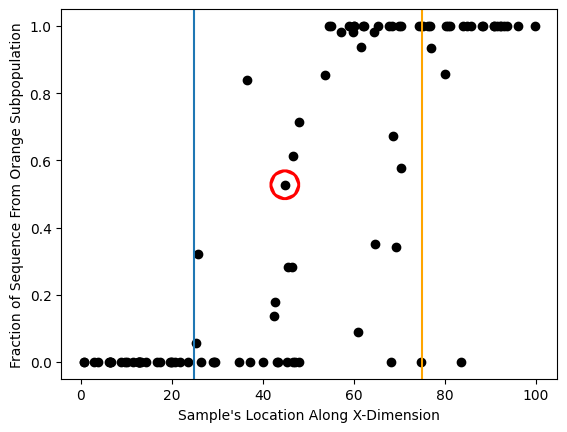

In [543]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[41], composition[41], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
plt.savefig("two_pops_composition.svg")
plt.show()

In [544]:
spatial_arg = sparg.SpatialARG(ts=ts_small, verbose=True)
spatial_arg.dispersal_rate_matrix = np.array([[0.25*0.25+0.5,0],[0,0.25*0.25+0.5]])

Prepared input parameters - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1886/1886 [00:00<00:00, 1960.05it/s]


Calculated covariance matrix - Section Elapsed Time: 0.97 - Total Elapsed Time: 0.97
Inverted covariance matrix - Section Elapsed Time: 0.07 - Total Elapsed Time: 1.04
Created root locations vector - Section Elapsed Time: 0.7 - Total Elapsed Time: 1.74
Estimated dispersal rate - Section Elapsed Time: 0.0 - Total Elapsed Time: 1.74
Calculated Fisher's information matrices - Section Elapsed Time: 0.0 - Total Elapsed Time: 1.74
Completed building SpatialARG object - Total Elapsed Time: 1.74


In [548]:
locations_df = sparg.create_ancestors_dataframe(ts=ts_sim, samples=[41], include_locations=True)

In [549]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(df=locations_df, spatial_arg=spatial_arg)

  0%|          | 0/8000 [00:00<?, ?it/s]

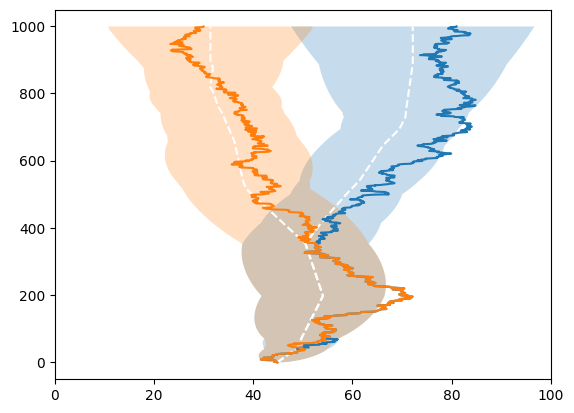

In [550]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    #if i == (32, 546534.5) or i == (32, 780505.0):
    if i == (41, 202442.5) or i == (41, 822112.5):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["arg_estimated_location_0"]-1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
            right.append(row["arg_estimated_location_0"]+1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["arg_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")
#for i,region in locations_df.groupby(["sample", "genome_position"]):
#    plt.plot(region["true_location_0"], region["time"], color="lightgray", zorder=0)
    
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        plt.plot(region["true_location_0"], region["time"])
plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors_fixed_confidence.svg")
plt.show()

In [551]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=0, use_theoretical_dispersal=True)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

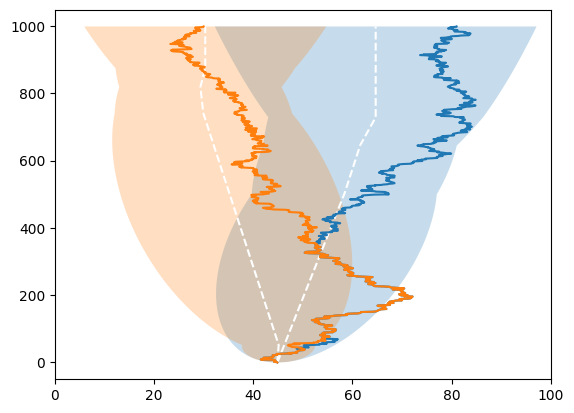

In [552]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_0_estimated_location_0"]-1.96*math.sqrt(round(row["window_0_variance_in_estimated_location_0"],3)))
            right.append(row["window_0_estimated_location_0"]+1.96*math.sqrt(round(row["window_0_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_0_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        plt.plot(region["true_location_0"], region["time"])
plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors_fixed_confidence_tree.svg")
plt.show()

In [554]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=100, use_theoretical_dispersal=True)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

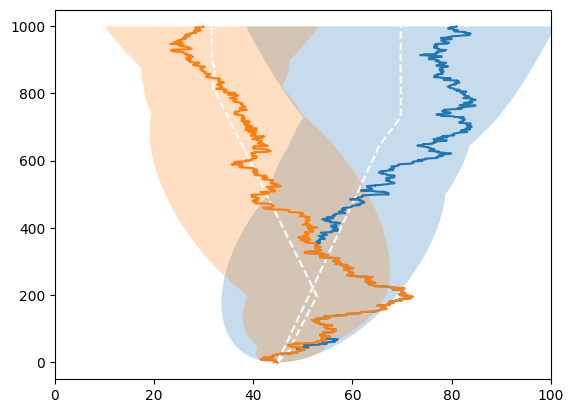

In [555]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_100_estimated_location_0"]-1.96*math.sqrt(round(row["window_100_variance_in_estimated_location_0"],3)))
            right.append(row["window_100_estimated_location_0"]+1.96*math.sqrt(round(row["window_100_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_100_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")  
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (41, 202442.5) or i == (41, 822112.5):
        plt.plot(region["true_location_0"], region["time"])
plt.xlim(0,100)
#plt.savefig("two_pops_genetic_ancestors_fixed_confidence_tree.svg")
plt.show()

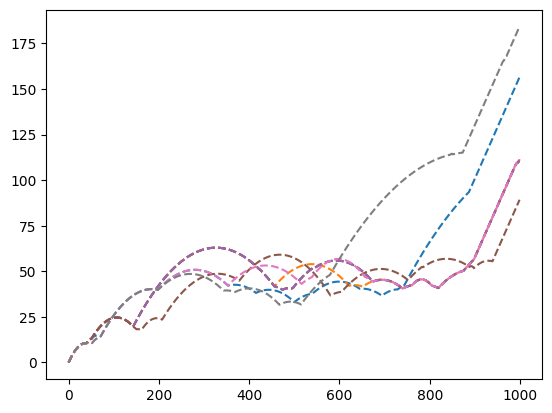

In [556]:



for i,region in locations_df.groupby(["sample", "genome_position"]):
    plt.plot(region["time"], region["arg_variance_in_estimated_location_0"], linestyle="dashed")
    #plt.plot(region["time"], region["window_0_variance_in_estimated_location_0"])
plt.show()

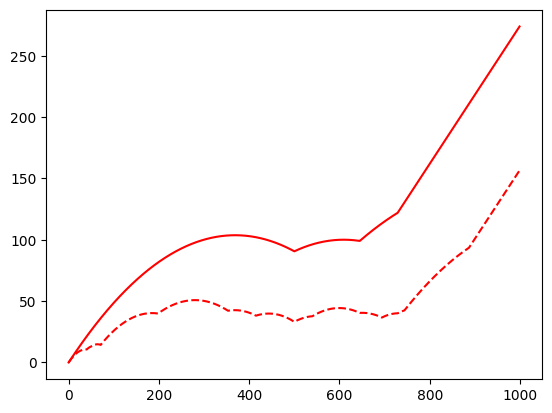

In [557]:
colors = ["red","blue","green","yellow","black","purple","orange","grey"]
c = 0
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if c == 0:
        plt.plot(region["time"], region["arg_variance_in_estimated_location_0"], linestyle="dashed", color=colors[c])
        plt.plot(region["time"], region["window_0_variance_in_estimated_location_0"], color=colors[c])
    c += 1

In [502]:
def ts_stacked(x=0.25, n=1, seq_len = 1000 ):     
    ts_stacked = tskit.TableCollection(sequence_length=1e3)
    n_nodes = 3 + n*3
    # n_steps = 3 + 2*n 
    
    node_table = ts_stacked.nodes
    flag_list = np.zeros((n_nodes,))
    flag_list[0] = 1
    flag_list[1] = 1
    time_list = np.zeros((n_nodes,))
    time_list[-1] = (3 +2*n )*x
    
    for i in range(n):
        flag_list[2 +3*i] = 131072
        flag_list[2 +3*i + 1] = 131072
        time_list[2 +3*i] = (3 + 2*i)*x
        time_list[2 +3*i + 1] = (3 + 2*i)*x
        time_list[2 +3*i + 2] = (3 + 2*i + 1)*x
    
    node_table.set_columns(
        flags = np.array(flag_list, dtype=np.uint32),
        time = np.array(time_list),
        individual = np.array(list(range(2)) + [-1 for i in range(n_nodes-2)], dtype = np.int32)
    )
    
    individual_table = ts_stacked.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_stacked.edges
    
    seqlen = seq_len/float(n+1)
    child = [0,0,1]
    parent = [2,3,4]
    left = [ seqlen, 0, 0  ]
    right = [ (n+1)*seqlen, seqlen, (n+1)*seqlen ] 
    for i in range(n-1): 
        child += [ 2 + 3*i, 2+3*i, 2+3*i+1, 2+3*i+2 ]
        parent += [ 2 + 3*(i+1), 2+3*(i+1)+1, 2+3*i+2, 2+3*(i+1)+2 ]
        left += [(i+2)*seqlen , (i+1)*seqlen , i*seqlen , (i+1)*seqlen ]
        right += [(n+1)*seqlen , (i+2)*seqlen , (i+1)*seqlen  , (n+1)*seqlen ]
    child += [2+3*(n-1), 3*n, 3*n+1  ]
    parent += [2+3*n, 3*n+1, 3*n+2 ]
    left += [n*seqlen, (n-1)*seqlen, n*seqlen ]
    right += [(n+1)*seqlen, n*seqlen, (n+1)*seqlen]
    
    # print(child)
    # print(parent)
    # print(left)
    # print(right)
    
    edge_table.set_columns(
        left=np.array(left),
        right=np.array(right),
        parent=np.array(parent, dtype=np.int32),  # References IDs in the node table
        child=np.array(child, dtype=np.int32),  # References IDs in the node table
    )
    ts_stacked.sort()
    return ts_stacked.tree_sequence()

ts = ts_stacked(n=3)
ts_tables = ts.dump_tables() 
ts_edges = ts_tables.edges
ts_edges.left = [250, 0, 0, 0, 500, 250, 0, 250, 750, 500, 0, 500, 750, 0]
ts_tables.sort() 
ts = ts_tables.tree_sequence()

In [503]:
spatial_arg = sparg.SpatialARG(ts=ts, verbose=True)

Prepared input parameters - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 5366.42it/s]

Calculated covariance matrix - Section Elapsed Time: 0.01 - Total Elapsed Time: 0.01
Inverted covariance matrix - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.01
Created root locations vector - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.01
Estimated dispersal rate - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.01
Calculated Fisher's information matrices - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.01
Completed building SpatialARG object - Total Elapsed Time: 0.01


In [516]:
check_df = sparg.create_ancestors_dataframe(ts=spatial_arg.ts, samples=[0,1], timestep=0.25, include_locations=False)

In [517]:
check_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(df=check_df, spatial_arg=spatial_arg)

  0%|          | 0/28 [00:00<?, ?it/s]

In [518]:
check_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=check_df, spatial_arg=spatial_arg, window_size=0, use_theoretical_dispersal=True)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [519]:
spatial_arg.dispersal_rate_matrix

array([[0.25548141]])

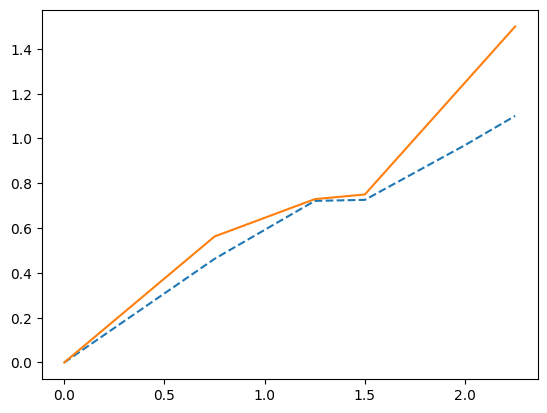

In [523]:
#for i,region in check_df.groupby(["sample", "genome_position"]):
    #if region["genome_position"] == 375.0:
    #plt.plot(region["time"], region["arg_variance_in_estimated_location_0"], linestyle="dashed")
    #plt.plot(region["time"], region["window_0_variance_in_estimated_location_0"])

plt.plot(check_df.loc[check_df["genome_position"] == 375.0, "time"], check_df.loc[check_df["genome_position"] == 375.0, "arg_variance_in_estimated_location_0"]/0.25548141, linestyle="dashed")    
plt.plot(check_df.loc[check_df["genome_position"] == 375.0, "time"], check_df.loc[check_df["genome_position"] == 375.0, "window_0_variance_in_estimated_location_0"]/(0.25*0.25+0.5))    
plt.show()

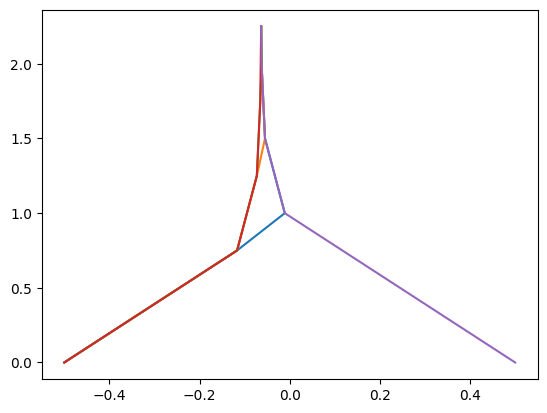

In [234]:
for i,region in check_df.groupby(["sample", "genome_position"]):
    plt.plot(region["arg_estimated_location_0"], region["time"])    
plt.show()